In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import time
import joblib

/home/nicekid/anaconda3/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
df2 = pd.read_csv('ML_Q2.csv')
df1 = pd.read_csv('ML_Q1.csv')
df = pd.merge(df1, df2, on="Order ID", how="right")

In [3]:
df.shape

(30967, 33)

In [4]:
df.head()

,Order ID,Sum of Profit,Sum of Quantity,Discount,Sum of Sales,Sum of Shipping Cost,Returned ID,MquarterN,mnime_x,mmonthN_x,...,mmonthN_y,mnime_y,MWeekDay_y,Ship Mode_y,Markets_y,Region_y,Country_y,City_y,Order Priority_y,Segment_y
0,AE-2011-9160,-246.077995,8,0.7,161.082001,9.560000,NaN,4,Second Half of Year,10,...,10,Second Half of Year,Monday,Standard Class,EMEA,EMEA,United Arab Emirates,Ajman,Medium,Consumer
1,AE-2013-1130,-236.964003,7,0.7,228.996001,60.180002,NaN,4,Second Half of Year,10,...,10,Second Half of Year,Monday,Same Day,EMEA,EMEA,United Arab Emirates,Ras al Khaymah,High,Consumer
2,AE-2013-1530,-38.076000,3,0.7,23.633999,3.160000,NaN,4,Second Half of Year,12,...,12,Second Half of Year,Tuesday,Second Class,EMEA,EMEA,United Arab Emirates,Ras al Khaymah,High,Corporate
3,AE-2014-2840,-75.059998,1,0.7,42.480000,8.040000,NaN,4,Second Half of Year,11,...,11,Second Half of Year,Wednesday,First Class,EMEA,EMEA,United Arab Emirates,Ajman,Critical,Consumer
4,AE-2014-3830,-429.107995,16,0.7,281.501994,19.380000,NaN,4,Second Half of Year,12,...,12,Second Half of Year,Saturday,Standard Class,EMEA,EMEA,United Arab Emirates,Ras al Khaymah,Medium,Consumer


In [5]:
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_data[missing_data['Missing Count'] > 0]

,Column,Missing Count,Missing Percentage
6,Returned ID,29307,94.64


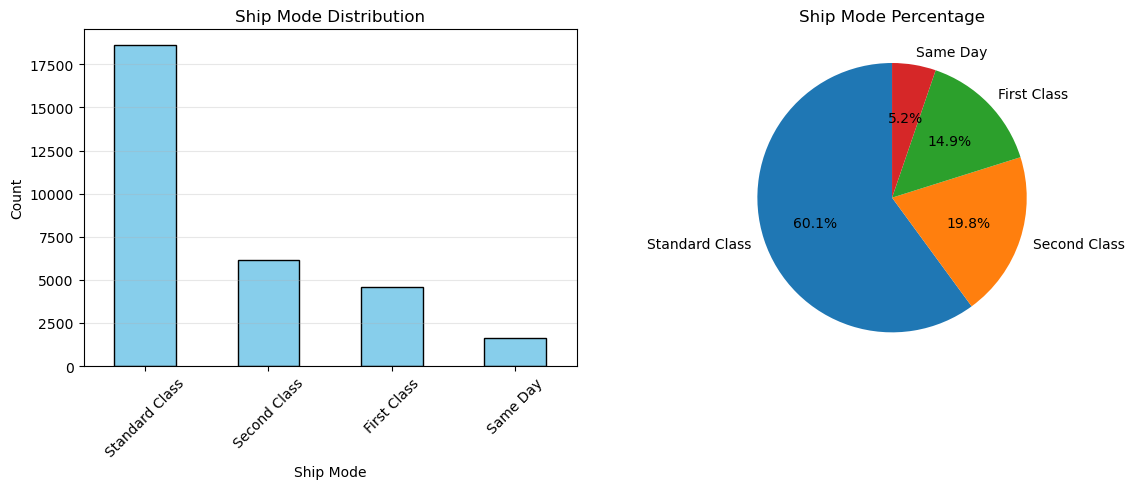

In [6]:
target_col = 'Ship Mode_y' if 'Ship Mode_y' in df.columns else 'Ship Mode_x' if 'Ship Mode_x' in df.columns else 'Ship Mode'

if target_col in df.columns:
    ship_mode_counts = df[target_col].value_counts()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    ship_mode_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Ship Mode Distribution')
    plt.xlabel('Ship Mode')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    ship_mode_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Ship Mode Percentage')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sum of Profit,30967.0,48.811412,256.447362,-6904.371979,-1.614,15.660000,71.459999,8762.393577
Sum of Quantity,30967.0,5.915006,5.047851,1.000000,2.000,4.000000,8.000000,58.000000
Discount,30967.0,0.154543,0.213743,0.000000,0.000,0.000000,0.200000,0.850000
Sum of Sales,30967.0,413.978600,714.874187,0.556000,51.902,164.070007,481.050003,23459.799988
Sum of Shipping Cost,30967.0,44.066644,83.657616,0.002000,4.530,14.980000,46.085001,2076.620026
MquarterN,30967.0,2.803339,1.066726,1.000000,2.000,3.000000,4.000000,4.000000
mmonthN_x,30967.0,7.558143,3.298480,1.000000,5.000,8.000000,10.000000,12.000000
MWeekNum,30967.0,31.439306,14.428482,1.000000,20.000,34.000000,44.000000,53.000000
Year_x,30967.0,2012.768302,1.103279,2011.000000,2012.000,2013.000000,2014.000000,2014.000000
Day,30967.0,15.754804,8.762563,1.000000,8.000,16.000000,23.000000,31.000000


In [8]:
if 'Ship Mode_x' in df.columns and 'Ship Mode_y' in df.columns:
    print(f"Ship Modes identical: {(df['Ship Mode_x'] == df['Ship Mode_y']).all()}")

Ship Modes identical: True


In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

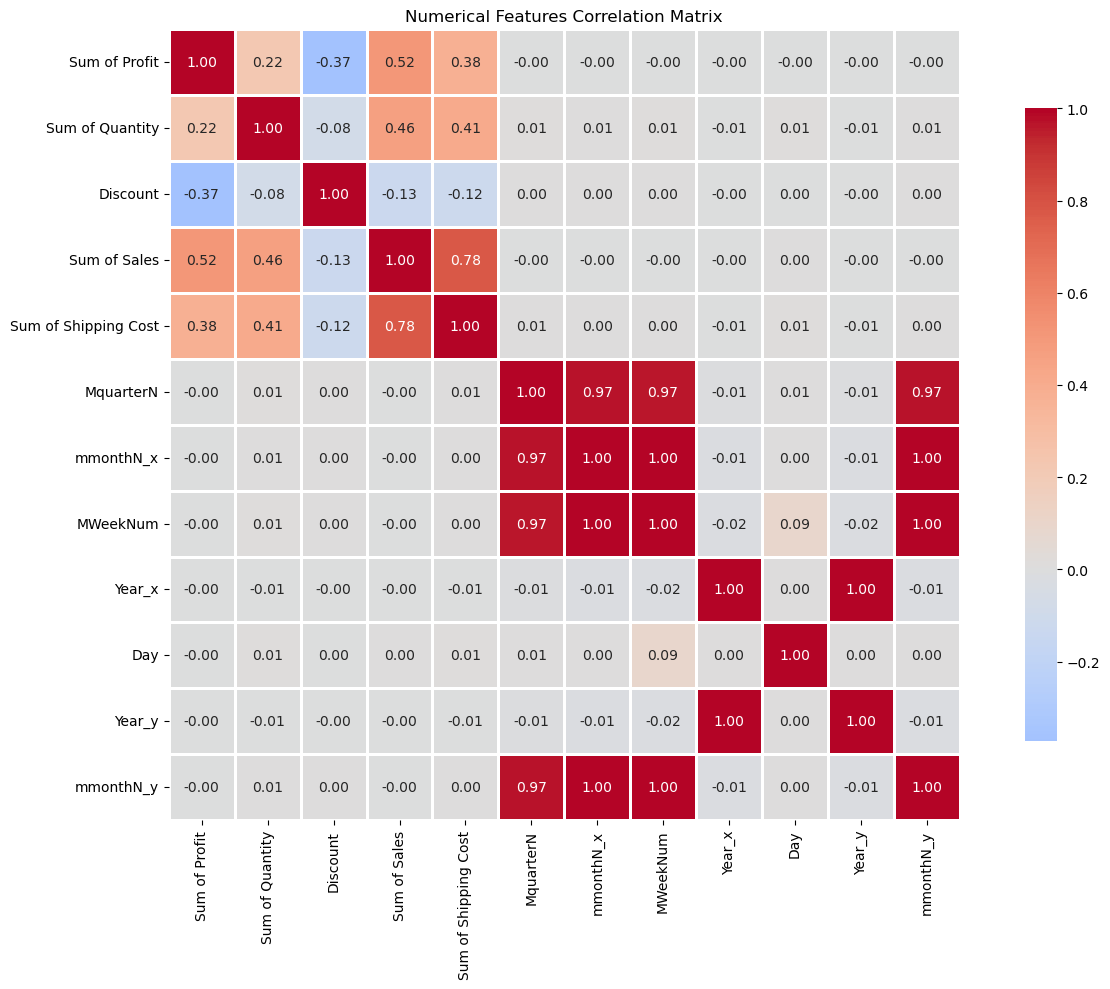

In [10]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Numerical Features Correlation Matrix')
plt.tight_layout()
plt.show()

high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Column 1': correlation_matrix.columns[i],
                'Column 2': correlation_matrix.columns[j],
                'Correlation': round(correlation_matrix.iloc[i, j], 3)
            })

if high_corr:
    pd.DataFrame(high_corr)

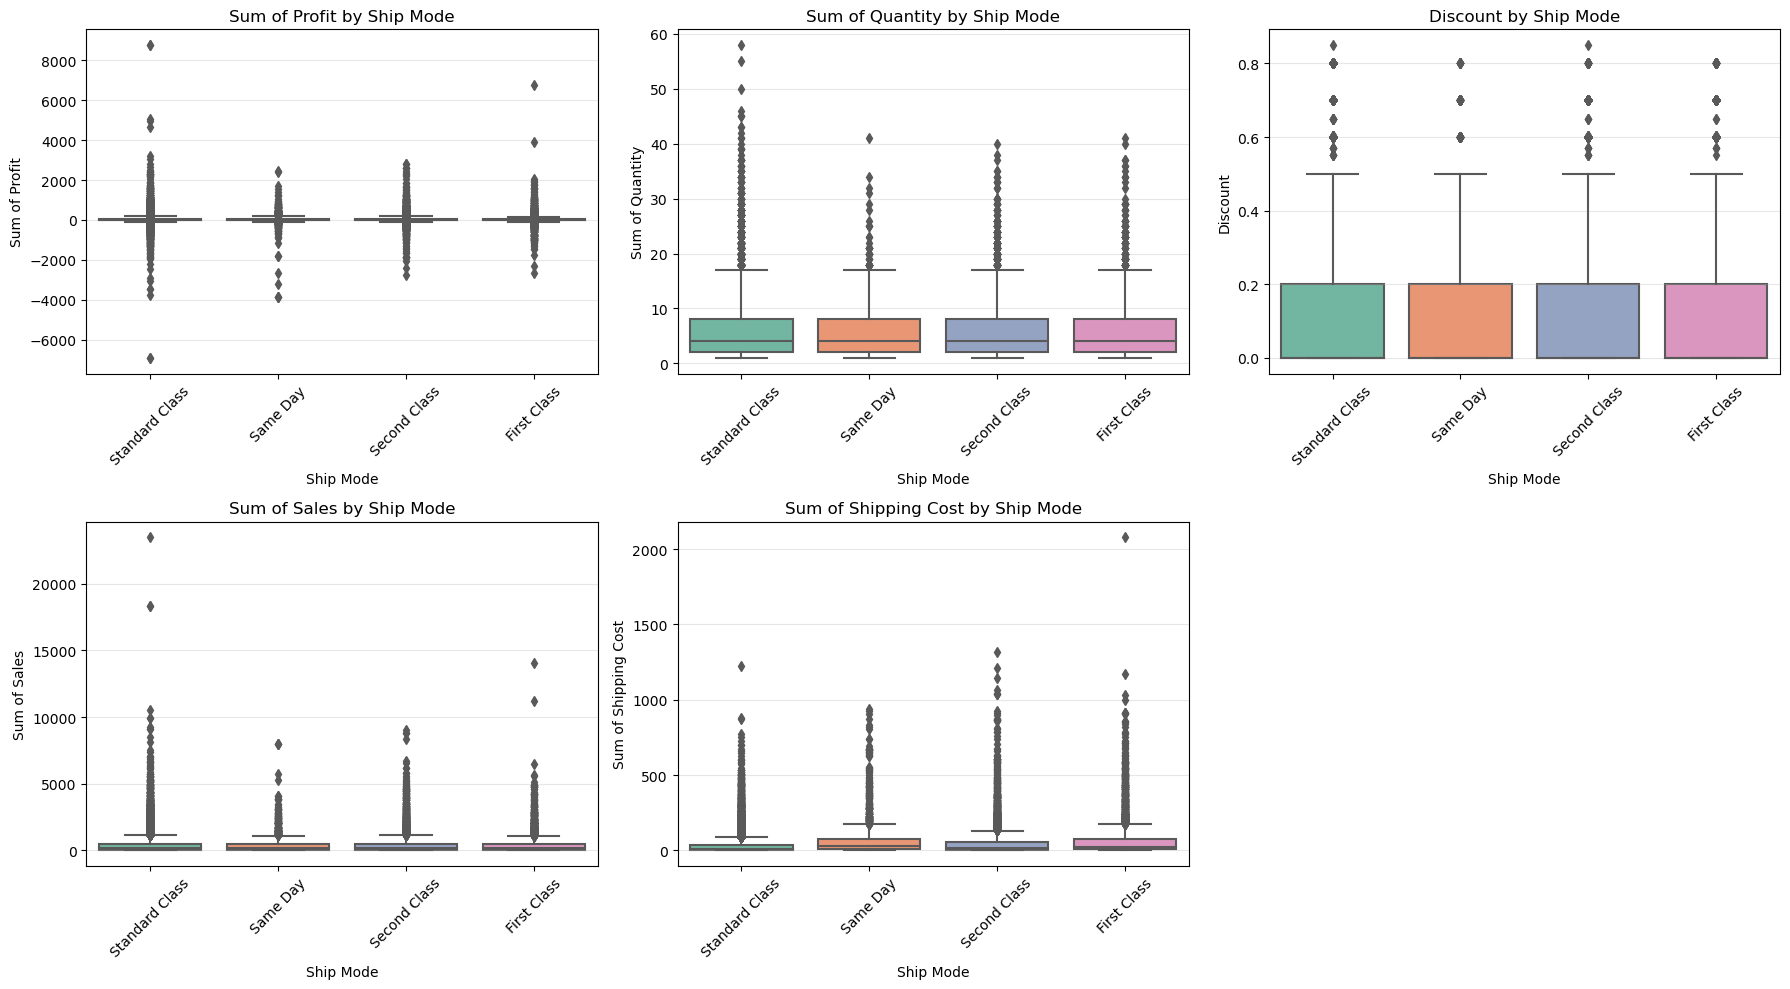

In [11]:
key_numeric_features = ['Sum of Profit', 'Sum of Quantity', 'Discount', 
                        'Sum of Sales', 'Sum of Shipping Cost']

available_features = [col for col in key_numeric_features if col in df.columns]

if available_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(available_features[:6]):
        sns.boxplot(data=df, x=target_col, y=col, ax=axes[idx], palette='Set2')
        axes[idx].set_title(f'{col} by Ship Mode')
        axes[idx].set_xlabel('Ship Mode')
        axes[idx].set_ylabel(col)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)
    
    for idx in range(len(available_features), 6):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

In [12]:
categorical_features = [col for col in categorical_cols 
                       if col not in [target_col, 'Ship Mode_x', 'Ship Mode_y', 'Order ID']]

chi_square_results = []

for col in categorical_features[:10]:
    if df[col].nunique() < 50:
        try:
            contingency_table = pd.crosstab(df[col], df[target_col])
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            chi_square_results.append({
                'Feature': col,
                'Chi-Square': round(chi2, 2),
                'P-Value': f"{p_value:.6f}",
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        except:
            pass

if chi_square_results:
    chi_df = pd.DataFrame(chi_square_results)
    chi_df.sort_values('Chi-Square', ascending=False)

In [13]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

outlier_summary = []

for col in available_features:
    n_outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Feature': col,
        'Outlier Count': n_outliers,
        'Percentage': round((n_outliers / len(df)) * 100, 2)
    })

pd.DataFrame(outlier_summary)

,Feature,Outlier Count,Percentage
0,Sum of Profit,5589,18.05
1,Sum of Quantity,1163,3.76
2,Discount,2547,8.22
3,Sum of Sales,2816,9.09
4,Sum of Shipping Cost,3206,10.35


In [14]:
df_processed = df.copy()

In [15]:
def remove_outliers_iqr(data, columns, factor=1.5):
    """Remove outliers using IQR method"""
    data_clean = data.copy()
    outliers_removed = 0
    
    for col in columns:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        before_count = len(data_clean)
        data_clean = data_clean[(data_clean[col] >= lower_bound) & (data_clean[col] <= upper_bound)]
        after_count = len(data_clean)
        outliers_removed += (before_count - after_count)
    
    return data_clean, outliers_removed

print(f"Original data shape: {df_processed.shape}")

numeric_cols_for_outliers = ['Sum of Profit', 'Sum of Quantity', 'Discount', 
                              'Sum of Sales', 'Sum of Shipping Cost']

available_numeric_cols = [col for col in numeric_cols_for_outliers if col in df_processed.columns]

df = df_processed.copy()
df, total_outliers = remove_outliers_iqr(df, available_numeric_cols, factor=1.5)

print(f"Data shape after removing outliers: {df.shape}")
print(f"Total outliers removed: {total_outliers}")
print(f"Percentage of data removed: {(total_outliers / len(df_processed)) * 100:.2f}%")

Original data shape: (30967, 33)
Data shape after removing outliers: (19728, 33)
Total outliers removed: 11239
Percentage of data removed: 36.29%


In [16]:
columns_to_drop = [
    'Order ID', 'Returned ID', 'Ship Mode_x', 'Order Priority_x',   
    'Markets_x', 'City_x', 'City_y', 'Country_x', 'Country_y',          
    'State', 'Region_x', 'Segment_x', 'MWeekDay_x',         
    'mnime_x', 'mnime_y', 'Year_x', 'mmonthN_x', 'MWeekNum'          
]

existing_cols_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
df_processed = df_processed.drop(columns=existing_cols_to_drop)

In [17]:
rename_dict = {}
for col in df_processed.columns:
    if col.endswith('_y'):
        new_name = col.replace('_y', '')
        rename_dict[col] = new_name

df_processed = df_processed.rename(columns=rename_dict)

In [18]:
target = 'Ship Mode'
X = df_processed.drop(columns=[target])
y = df_processed[target]
y.value_counts()

Standard Class    18600
Second Class       6130
First Class        4612
Same Day           1625
Name: Ship Mode, dtype: int64

In [19]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [20]:
X_encoded = X.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

X_encoded.head()

,Sum of Profit,Sum of Quantity,Discount,Sum of Sales,Sum of Shipping Cost,MquarterN,Day,Year,mmonthN,MWeekDay,Markets,Region,Order Priority,Segment
0,-246.077995,8,0.7,161.082001,9.560000,4,3,2011,10,1,3,5,3,0
1,-236.964003,7,0.7,228.996001,60.180002,4,14,2013,10,1,3,5,1,0
2,-38.076000,3,0.7,23.633999,3.160000,4,31,2013,12,5,3,5,1,1
3,-75.059998,1,0.7,42.480000,8.040000,4,5,2014,11,6,3,5,0,0
4,-429.107995,16,0.7,281.501994,19.380000,4,13,2014,12,2,3,5,3,0


In [21]:
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Train: X{X_train.shape}, y{y_train.shape}")
print(f"Test: X{X_test.shape}, y{y_test.shape}")

Train: X(24773, 14), y(24773,)
Test: X(6194, 14), y(6194,)


In [23]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

X_train_scaled[numeric_features].describe().T[['mean', 'std']].head()

,mean,std
Sum of Profit,5.951545e-18,1.00002
Sum of Quantity,8.031000e-17,1.00002
Discount,-3.413175e-17,1.00002
Sum of Sales,-1.032557e-17,1.00002
Sum of Shipping Cost,7.170536e-20,1.00002


In [24]:
models_baseline = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(kernel='rbf', random_state=42),
    'CatBoost': CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, random_state=42, verbose=False),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, eval_metric='mlogloss')
}

results_baseline = {}

for model_name, model in models_baseline.items():
    start_time = time.time()
    
    model.fit(X_train_scaled, y_train)
    
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    training_time = time.time() - start_time
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    results_baseline[model_name] = {
        'Model': model,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Training Time': training_time,
        'Predictions': y_pred_test
    }
    
    print(f"{model_name}: Test={test_accuracy:.4f}")

Logistic Regression: Test=0.6393
Decision Tree: Test=0.5885
Decision Tree: Test=0.5885
Random Forest: Test=0.6757
Random Forest: Test=0.6757
K-Nearest Neighbors: Test=0.5618
K-Nearest Neighbors: Test=0.5618
Support Vector Machine: Test=0.6334
Support Vector Machine: Test=0.6334
CatBoost: Test=0.6703
CatBoost: Test=0.6703
XGBoost: Test=0.6755
XGBoost: Test=0.6755


In [25]:
comparison_baseline = pd.DataFrame({
    'Model': list(results_baseline.keys()),
    'Train Accuracy': [results_baseline[m]['Train Accuracy'] for m in results_baseline.keys()],
    'Test Accuracy': [results_baseline[m]['Test Accuracy'] for m in results_baseline.keys()],
    'Precision': [results_baseline[m]['Precision'] for m in results_baseline.keys()],
    'Recall': [results_baseline[m]['Recall'] for m in results_baseline.keys()],
    'F1-Score': [results_baseline[m]['F1-Score'] for m in results_baseline.keys()],
    'Time (s)': [results_baseline[m]['Training Time'] for m in results_baseline.keys()]
})

comparison_baseline = comparison_baseline.sort_values('Test Accuracy', ascending=False)

comparison_baseline.style.format({
    'Train Accuracy': '{:.4f}',
    'Test Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Time (s)': '{:.2f}'
}).background_gradient(subset=['Test Accuracy'], cmap='Greens')

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Time (s)
2,Random Forest,1.0000,0.6757,0.6419,0.6757,0.6115,5.36
6,XGBoost,0.7785,0.6755,0.6153,0.6755,0.6141,2.03
5,CatBoost,0.6931,0.6703,0.6336,0.6703,0.5846,2.86
0,Logistic Regression,0.6405,0.6393,0.5335,0.6393,0.5402,0.59
4,Support Vector Machine,0.6421,0.6334,0.5242,0.6334,0.5242,61.40
1,Decision Tree,1.0000,0.5885,0.5971,0.5885,0.5926,0.37
3,K-Nearest Neighbors,0.6998,0.5618,0.5135,0.5618,0.5321,6.78


In [26]:
X_featured = X.copy()

X_featured['Profit_Margin'] = X_featured['Sum of Profit'] / (X_featured['Sum of Sales'] + 1e-6)
X_featured['Avg_Price_Per_Unit'] = X_featured['Sum of Sales'] / (X_featured['Sum of Quantity'] + 1e-6)
X_featured['Shipping_Cost_Ratio'] = X_featured['Sum of Shipping Cost'] / (X_featured['Sum of Sales'] + 1e-6)
X_featured['Total_Cost'] = X_featured['Sum of Sales'] - X_featured['Sum of Profit']
X_featured['Profit_Per_Unit'] = X_featured['Sum of Profit'] / (X_featured['Sum of Quantity'] + 1e-6)

X_featured['Log_Sales'] = np.log1p(X_featured['Sum of Sales'])
X_featured['Log_Profit_Positive'] = np.log1p(X_featured['Sum of Profit'] - X_featured['Sum of Profit'].min() + 1)
X_featured['Sqrt_Quantity'] = np.sqrt(X_featured['Sum of Quantity'])

X_featured['Sales_Quantity'] = X_featured['Sum of Sales'] * X_featured['Sum of Quantity']
X_featured['Discount_Impact'] = X_featured['Discount'] * X_featured['Sum of Sales']

X_featured['Is_Weekend'] = X_featured['MWeekDay'].isin(['Saturday', 'Sunday']).astype(int)
X_featured['Is_Month_End'] = (X_featured['Day'] >= 25).astype(int)
X_featured['Quarter'] = ((X_featured['mmonthN'] - 1) // 3 + 1)

X_featured['Sales_Squared'] = X_featured['Sum of Sales'] ** 2
X_featured['Profit_Squared'] = X_featured['Sum of Profit'] ** 2

X_featured.shape

(30967, 29)

In [27]:
numeric_features_new = X_featured.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_new = X_featured.select_dtypes(include=['object']).columns.tolist()

X_encoded_new = X_featured.copy()
label_encoders_new = {}

for col in categorical_features_new:
    le = LabelEncoder()
    X_encoded_new[col] = le.fit_transform(X_encoded_new[col])
    label_encoders_new[col] = le

In [28]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_encoded_new, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

scaler_new = StandardScaler()
X_train_scaled_new = X_train_new.copy()
X_test_scaled_new = X_test_new.copy()

X_train_scaled_new[numeric_features_new] = scaler_new.fit_transform(X_train_new[numeric_features_new])
X_test_scaled_new[numeric_features_new] = scaler_new.transform(X_test_new[numeric_features_new])

In [29]:
models_new = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(kernel='rbf', random_state=42),
    'CatBoost': CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, random_state=42, verbose=False),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, eval_metric='mlogloss')
}

results_new = {}

for model_name, model in models_new.items():
    start_time = time.time()
    
    model.fit(X_train_scaled_new, y_train_new)
    
    y_pred_train = model.predict(X_train_scaled_new)
    y_pred_test = model.predict(X_test_scaled_new)
    
    training_time = time.time() - start_time
    
    train_accuracy = accuracy_score(y_train_new, y_pred_train)
    test_accuracy = accuracy_score(y_test_new, y_pred_test)
    precision = precision_score(y_test_new, y_pred_test, average='weighted', zero_division=0)
    recall = recall_score(y_test_new, y_pred_test, average='weighted', zero_division=0)
    f1 = f1_score(y_test_new, y_pred_test, average='weighted', zero_division=0)
    
    results_new[model_name] = {
        'Model': model,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Training Time': training_time,
        'Predictions': y_pred_test
    }
    
    print(f"{model_name}: Test={test_accuracy:.4f}")

Logistic Regression: Test=0.6606
Decision Tree: Test=0.5907
Decision Tree: Test=0.5907
Random Forest: Test=0.7015
Random Forest: Test=0.7015
K-Nearest Neighbors: Test=0.5920
K-Nearest Neighbors: Test=0.5920
Support Vector Machine: Test=0.6581
Support Vector Machine: Test=0.6581
CatBoost: Test=0.6842
CatBoost: Test=0.6842
XGBoost: Test=0.6837
XGBoost: Test=0.6837


In [30]:
comparison_df_new = pd.DataFrame({
    'Model': list(results_new.keys()),
    'Train Accuracy': [results_new[m]['Train Accuracy'] for m in results_new.keys()],
    'Test Accuracy': [results_new[m]['Test Accuracy'] for m in results_new.keys()],
    'Precision': [results_new[m]['Precision'] for m in results_new.keys()],
    'Recall': [results_new[m]['Recall'] for m in results_new.keys()],
    'F1-Score': [results_new[m]['F1-Score'] for m in results_new.keys()],
    'Time (s)': [results_new[m]['Training Time'] for m in results_new.keys()]
})

comparison_df_new = comparison_df_new.sort_values('Test Accuracy', ascending=False)

comparison_df_new.style.format({
    'Train Accuracy': '{:.4f}',
    'Test Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Time (s)': '{:.2f}'
}).background_gradient(subset=['Test Accuracy'], cmap='Blues')

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Time (s)
2,Random Forest,1.0000,0.7015,0.6693,0.7015,0.6557,15.69
5,CatBoost,0.7112,0.6842,0.6558,0.6842,0.6209,3.82
6,XGBoost,0.7890,0.6837,0.6284,0.6837,0.6292,3.76
0,Logistic Regression,0.6636,0.6606,0.5672,0.6606,0.5848,0.94
4,Support Vector Machine,0.6691,0.6581,0.5794,0.6581,0.5611,71.53
3,K-Nearest Neighbors,0.7114,0.5920,0.5340,0.5920,0.5542,3.74
1,Decision Tree,1.0000,0.5907,0.5968,0.5907,0.5937,1.08


In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores_original = cross_val_score(rf_original, X_train_scaled_new, y_train_new, cv=cv, scoring='accuracy')
rf_original.fit(X_train_scaled_new, y_train_new)
train_acc_original = rf_original.score(X_train_scaled_new, y_train_new)
test_acc_original = rf_original.score(X_test_scaled_new, y_test_new)

rf_regularized = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
cv_scores_regularized = cross_val_score(rf_regularized, X_train_scaled_new, y_train_new, cv=cv, scoring='accuracy')
rf_regularized.fit(X_train_scaled_new, y_train_new)
train_acc_regularized = rf_regularized.score(X_train_scaled_new, y_train_new)
test_acc_regularized = rf_regularized.score(X_test_scaled_new, y_test_new)

comparison_cv = pd.DataFrame({
    'Model': ['Original RF', 'Regularized RF'],
    'CV Mean': [cv_scores_original.mean(), cv_scores_regularized.mean()],
    'CV Std': [cv_scores_original.std(), cv_scores_regularized.std()],
    'Train Acc': [train_acc_original, train_acc_regularized],
    'Test Acc': [test_acc_original, test_acc_regularized],
    'Overfitting Gap': [train_acc_original - test_acc_original, train_acc_regularized - test_acc_regularized]
})
comparison_cv

,Model,CV Mean,CV Std,Train Acc,Test Acc,Overfitting Gap
0,Original RF,0.697776,0.005672,1.000000,0.701485,0.298515
1,Regularized RF,0.687684,0.005709,0.771808,0.685018,0.086790


In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [12, 15, 18, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2']
}

rf_grid = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_scaled_new, y_train_new)
elapsed_time = time.time() - start_time

print(f"Grid Search completed in {elapsed_time:.2f} seconds")
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

rf_best = grid_search.best_estimator_
train_acc_best = rf_best.score(X_train_scaled_new, y_train_new)
test_acc_best = rf_best.score(X_test_scaled_new, y_test_new)
cv_scores_best = cross_val_score(rf_best, X_train_scaled_new, y_train_new, cv=cv, scoring='accuracy')

comparison_final = pd.DataFrame({
    'Model': ['Original RF', 'Regularized RF', 'Best Tuned RF'],
    'CV Mean': [cv_scores_original.mean(), cv_scores_regularized.mean(), cv_scores_best.mean()],
    'CV Std': [cv_scores_original.std(), cv_scores_regularized.std(), cv_scores_best.std()],
    'Train Acc': [train_acc_original, train_acc_regularized, train_acc_best],
    'Test Acc': [test_acc_original, test_acc_regularized, test_acc_best],
    'Overfitting Gap': [
        train_acc_original - test_acc_original, 
        train_acc_regularized - test_acc_regularized,
        train_acc_best - test_acc_best
    ]
})
comparison_final

In [ ]:
param_grid_xgb = {
    'n_estimators': [150, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [3, 5],
    'gamma': [0, 0.1]
}

xgb_grid = XGBClassifier(random_state=42, tree_method='hist', eval_metric='mlogloss')

grid_search_xgb = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
grid_search_xgb.fit(X_train_scaled_new, y_train_new)
elapsed_time = time.time() - start_time

print(f"Grid Search completed in {elapsed_time:.2f} seconds")
print(f"Best CV Score: {grid_search_xgb.best_score_:.4f}")
print(f"Best Parameters: {grid_search_xgb.best_params_}")

xgb_best = grid_search_xgb.best_estimator_
train_acc_xgb_best = xgb_best.score(X_train_scaled_new, y_train_new)
test_acc_xgb_best = xgb_best.score(X_test_scaled_new, y_test_new)
cv_scores_xgb_best = cross_val_score(xgb_best, X_train_scaled_new, y_train_new, cv=cv, scoring='accuracy')

print(f"\nTrain Accuracy: {train_acc_xgb_best:.4f}")
print(f"Test Accuracy: {test_acc_xgb_best:.4f}")
print(f"CV Mean: {cv_scores_xgb_best.mean():.4f} (+/- {cv_scores_xgb_best.std():.4f})")

y_pred_xgb = xgb_best.predict(X_test_scaled_new)
print(classification_report(y_test_new, y_pred_xgb, target_names=target_encoder.classes_))

cm = confusion_matrix(y_test_new, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.title('Confusion Matrix - Best XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

if hasattr(X_train_scaled_new, 'columns'):
    feature_names = X_train_scaled_new.columns
else:
    feature_names = [f'Feature_{i}' for i in range(X_train_scaled_new.shape[1])]

feature_importance_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top_15 = feature_importance_xgb.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

xgb_original = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_original.fit(X_train_scaled_new, y_train_new)
train_acc_xgb_original = xgb_original.score(X_train_scaled_new, y_train_new)
test_acc_xgb_original = xgb_original.score(X_test_scaled_new, y_test_new)
cv_scores_xgb_original = cross_val_score(xgb_original, X_train_scaled_new, y_train_new, cv=cv, scoring='accuracy')

xgb_regularized = XGBClassifier(
    n_estimators=200, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
    gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
    random_state=42, eval_metric='mlogloss'
)
xgb_regularized.fit(X_train_scaled_new, y_train_new)
train_acc_xgb_regularized = xgb_regularized.score(X_train_scaled_new, y_train_new)
test_acc_xgb_regularized = xgb_regularized.score(X_test_scaled_new, y_test_new)
cv_scores_xgb_regularized = cross_val_score(xgb_regularized, X_train_scaled_new, y_train_new, cv=cv, scoring='accuracy')

comparison_xgb = pd.DataFrame({
    'Model': ['Original XGBoost', 'Regularized XGBoost', 'Best Tuned XGBoost'],
    'CV Mean': [cv_scores_xgb_original.mean(), cv_scores_xgb_regularized.mean(), cv_scores_xgb_best.mean()],
    'CV Std': [cv_scores_xgb_original.std(), cv_scores_xgb_regularized.std(), cv_scores_xgb_best.std()],
    'Train Acc': [train_acc_xgb_original, train_acc_xgb_regularized, train_acc_xgb_best],
    'Test Acc': [test_acc_xgb_original, test_acc_xgb_regularized, test_acc_xgb_best],
    'Overfitting Gap': [
        train_acc_xgb_original - test_acc_xgb_original, 
        train_acc_xgb_regularized - test_acc_xgb_regularized,
        train_acc_xgb_best - test_acc_xgb_best
    ]
})
comparison_xgb

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/home/nicekid/anaconda3/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/nicekid/anaconda3/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. C

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   7.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; tota

In [ ]:
all_models_comparison = pd.DataFrame({
    'Model': [
        'Baseline - Best Model',
        'Feature Eng. - Best Model',
        'RF - Original (Overfitted)',
        'RF - Regularized',
        'RF - Best Tuned (GridSearch)',
        'XGBoost - Original',
        'XGBoost - Regularized',
        'XGBoost - Best Tuned (GridSearch)'
    ],
    'Test Accuracy': [
        comparison_baseline['Test Accuracy'].max(),
        comparison_df_new['Test Accuracy'].max(),
        test_acc_original,
        test_acc_regularized,
        test_acc_best,
        test_acc_xgb_original,
        test_acc_xgb_regularized,
        test_acc_xgb_best
    ],
    'CV Score': [
        np.nan,
        np.nan,
        cv_scores_original.mean(),
        cv_scores_regularized.mean(),
        cv_scores_best.mean(),
        cv_scores_xgb_original.mean(),
        cv_scores_xgb_regularized.mean(),
        cv_scores_xgb_best.mean()
    ],
    'Category': [
        'Baseline',
        'Feature Engineering',
        'Random Forest',
        'Random Forest',
        'Random Forest',
        'XGBoost',
        'XGBoost',
        'XGBoost'
    ]
})

all_models_comparison = all_models_comparison.sort_values('Test Accuracy', ascending=False)

all_models_comparison.style.format({
    'Test Accuracy': '{:.4f}',
    'CV Score': '{:.4f}'
}).background_gradient(subset=['Test Accuracy'], cmap='Greens')

,Model,Test Accuracy,CV Score,Category
1,Feature Eng. - Best Model,0.7015,nan,Feature Engineering
2,RF - Original (Overfitted),0.7015,0.6978,Random Forest
3,RF - Regularized,0.6850,0.6877,Random Forest
4,XGBoost,0.6837,0.6837,XGBoost
0,Baseline - Best Model,0.6757,nan,Baseline
